## Project description: Steel melting temperature prediction
To optimize production costs, the metallurgical plant decided to reduce energy consumption at the steel processing stage. To do this, the plant needs to control the temperature of the alloy. The task is to build a model that will predict it.

Description of the processing stage

The steel is processed in a metal ladle with a capacity of about 100 tons. To ensure that the ladle can withstand high temperatures, the inside is lined with refractory bricks. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the bucket lid.
Sulfur is removed from the alloy (this process is desulfurization), the chemical composition is adjusted by adding impurities, and samples are taken. The steel is alloyed - its composition is changed - by feeding pieces of the alloy from a bunker for bulk materials or wire through a special tribe apparatus .
Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is performed. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is mixed and measurements are taken again. This cycle is repeated until the target chemical composition and optimal melting temperature are achieved.
Then the molten steel is sent for metal finishing or enters a continuous casting machine. From there the finished product comes out in the form of slabs.

1.1 Data loading and primary processing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

data_arc_new.csv — data about electrodes;  
data_bulk_new.csv — data on the supply of bulk materials (volume);  
data_bulk_time_new.csv — data on the supply of bulk materials (time);  
data_gas_new.csv — data on purging the alloy with gas;  
data_temp_new.csv — temperature measurement results;  
data_wire_new.csv — data on wire materials (volume);  
data_wire_time_new.csv - data about wire materials (time).  

In [2]:
try: 
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
    
except:
    data_arc_new = pd.read_csv('/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/data_gas_new.csv')
    data_temp_new = pd.read_csv('/data_temp_new.csv')
    data_wire_new = pd.read_csv('/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/data_wire_time_new.csv')
    
    

In [3]:
def describe_data(data, bins, size):
   
    display(data.head(10))
    data.info()
    display(data.describe())
    data.drop('key',axis=1).hist( bins= bins,figsize=size)
    
    plt.show()
    data.drop('key', axis=1).boxplot()
    

Let's conduct an initial data analysis:

**Electrode data:**

In [ ]:
describe_data(data_arc_new, 20, (10,5))

There are no gaps. In the 'Reactive power' column there is an outlier with a value of ~-700, let's remove it.
Also in the data you need to bring the column names to the generally accepted form.

In [ ]:
data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой':'arc_heating_start',
                                            'Конец нагрева дугой':'arc_heating_end',
                                           'Активная мощность':'active_power',
                                           'Реактивная мощность':'reactive_power'})


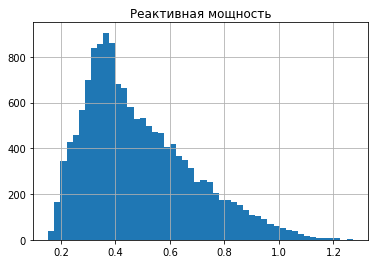

In [6]:
data_arc_new = data_arc_new[data_arc_new['reactive_power']>-100]
data_arc_new['reactive_power'].hist(bins=50)
plt.title('Реактивная мощность')
plt.show()

**Data on supply of bulk materials (volume):**

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


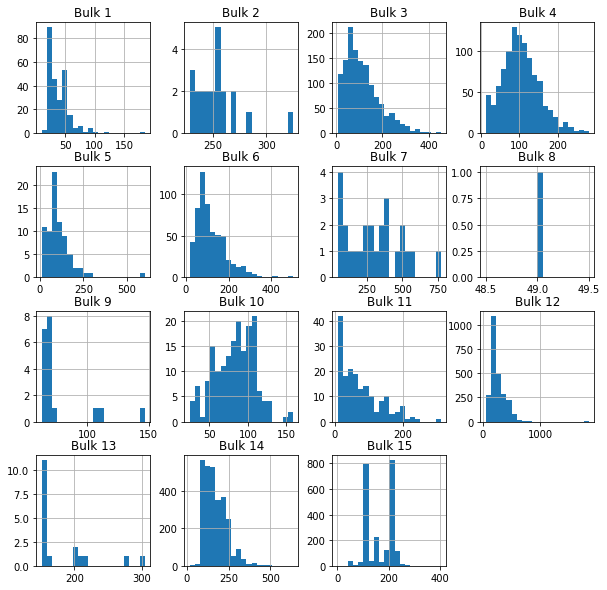

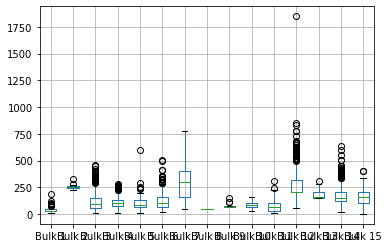

In [7]:
describe_data(data_bulk_new,20, (10,10))

There are many gaps in the material data, which means that these materials were not added at a certain iteration. The gap can be replaced with 0. Let's remove the space in the column names and remove the outlier for the volume Bulk 12. Bulk 8,9,13,2 can be removed because very few lines are contained with them.

In [8]:
data_bulk_new.columns = data_bulk_new.columns.str.replace(' ', '_')
data_bulk_new = data_bulk_new.drop(['Bulk_8','Bulk_9','Bulk_13','Bulk_2'], axis=1)

In [9]:
#data_bulk_new = data_bulk_new.query('Bulk_12<1750') 

It is not clear from the data what exactly these materials are, only the volume and time are given, so they cannot be aggregated by batch. Let's see which of these materials were used more and which less.

In [ ]:
data_bulk_new = data_bulk_new.fillna(0)

df_bulk_sorted = (data_bulk_new.drop('key',axis=1).sum())
df_bulk_sorted= pd.DataFrame(data=df_bulk_sorted, columns=['Vol'] ).sort_values(by ='Vol', ascending=False)
df_bulk_sorted

In [11]:
data_bulk_new.isna().sum()

key        0
Bulk_1     0
Bulk_3     0
Bulk_4     0
Bulk_5     0
Bulk_6     0
Bulk_7     0
Bulk_10    0
Bulk_11    0
Bulk_12    0
Bulk_14    0
Bulk_15    0
dtype: int64

The largest volume of bulk additive was for materials Bulk 12, 14, 15, 3, 4. The smallest was 13, 9, 8.

**Data on supply of bulk materials (time):**

In [12]:
data_bulk_time_new.columns = data_bulk_time_new.columns.str.replace(' ', '_')
display(data_bulk_time_new.head())
data_bulk_time_new.info()


,key,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk_1   252 non-null    object
 2   Bulk_2   22 non-null     object
 3   Bulk_3   1298 non-null   object
 4   Bulk_4   1014 non-null   object
 5   Bulk_5   77 non-null     object
 6   Bulk_6   576 non-null    object
 7   Bulk_7   25 non-null     object
 8   Bulk_8   1 non-null      object
 9   Bulk_9   19 non-null     object
 10  Bulk_10  176 non-null    object
 11  Bulk_11  177 non-null    object
 12  Bulk_12  2450 non-null   object
 13  Bulk_13  18 non-null     object
 14  Bulk_14  2806 non-null   object
 15  Bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Accordingly, the time data is also empty if there were no additives. Submission time data may not be taken into account in the problem.

**Data on alloy gas purging:**

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


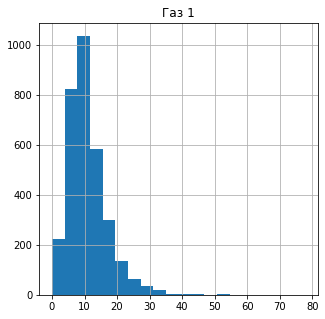

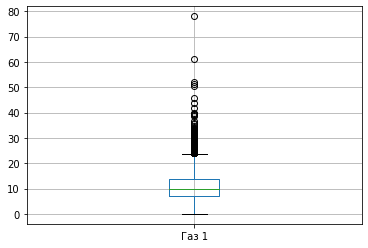

In [13]:
describe_data(data_gas_new,20, (5,5))


There are no gaps, the average value is about 10. Let's replace the column names.

In [ ]:
data_gas_new= data_gas_new.rename(columns={'Газ 1':'Gas_1'})

**Temperature measurement results:**

In [15]:
data_temp_new = data_temp_new.rename(columns={'Время замера':'measure_time', 'Температура':'temperature'})


,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   measure_time  18092 non-null  object 
 2   temperature   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,temperature
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


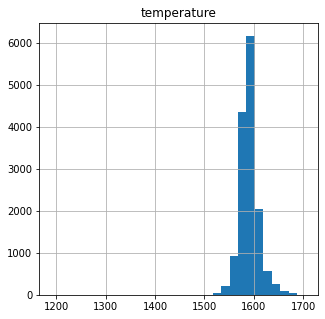

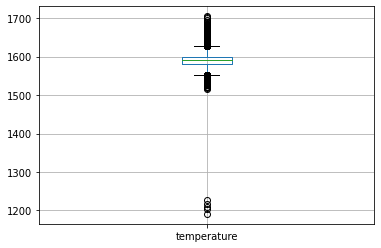

In [16]:
describe_data(data_temp_new,30, (5,5))

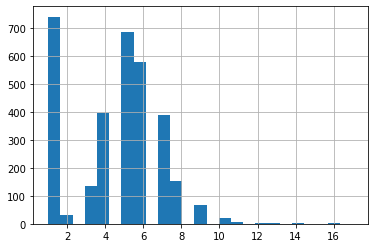

In [17]:
data_temp_new.groupby('key')['temperature'].count().hist(bins=25)
plt.show()

In [18]:
data_temp_new['temperature'].isna().sum()

3427

Temperature measurements at iterations are given for each batch. Quite a lot of gaps for temperature were found here, since this is the target attribute, you need to delete the lines with these gaps. There are also emissions in the region of 1200 degrees, the melting point of steel is much higher, so we delete these lines too.

In [19]:
data_temp_new = data_temp_new.query('temperature>1500')
data_temp_new = data_temp_new.dropna()
#проверка на пропуски:
data_temp_new['temperature'].isna().sum()

0

In [20]:
data_temp_new['measure_time'] = pd.to_datetime(
    data_temp_new['measure_time'], format='%Y-%m-%dT%H:%M:%S' )

**Data on wire materials (volume):**

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


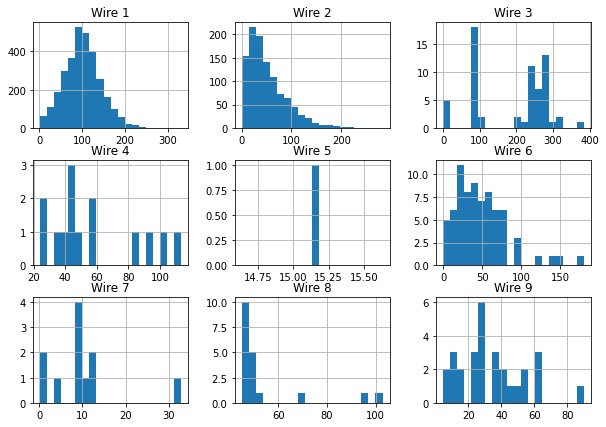

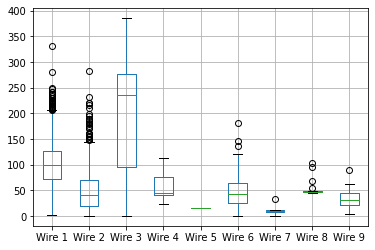

In [21]:
describe_data(data_wire_new, 20, (10,7))


Here you can also replace spaces with 0.


In [22]:
data_wire_new = data_wire_new.fillna(0)
data_wire_new.columns = data_wire_new.columns.str.replace(' ', '_')
data_wire_new.head()

,key,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
data_wire_sorted = (data_wire_new.drop('key',axis=1).sum())
data_wire_sorted= pd.DataFrame(data=data_wire_sorted, columns=['Vol'] ).sort_values(by ='Vol', ascending=False)
data_wire_sorted

,Vol
Wire_1,308236.830606
Wire_2,54572.931650
Wire_3,11937.408916
Wire_6,3505.239099
Wire_8,1018.878666
Wire_9,990.516814
Wire_4,804.199781
Wire_7,110.429080
Wire_5,15.132000


Let's remove types of material for which there is very little data - Wire 5, 4, 7, 8, 9.

In [24]:
data_wire_new = data_wire_new.drop(['Wire_5','Wire_4', 'Wire_7','Wire_8','Wire_9'],axis=1)

**Data on the introduction of wire materials (time):**

In [25]:
data_wire_time_new.columns = data_wire_time_new.columns.str.replace(' ', '_')
display(data_wire_time_new.head(10))
data_wire_time_new.info()

,key,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire_1  3055 non-null   object
 2   Wire_2  1079 non-null   object
 3   Wire_3  63 non-null     object
 4   Wire_4  14 non-null     object
 5   Wire_5  1 non-null      object
 6   Wire_6  73 non-null     object
 7   Wire_7  11 non-null     object
 8   Wire_8  19 non-null     object
 9   Wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Data on the time of insertion of the wire are not important, and they also can be ignored in the problem.

### Conclusion on part 1:

- Data collected from various sources. Outliers were detected and eliminated for reactive power and temperature measurements.
- Time data is not in the correct format.
- The target characteristic is the measurement temperature at the last iteration, which corresponds to the proper chemical composition of the steel. Using intermediate temperature values will be a data leak, so you need to leave the original temperature value as the input feature and the final value as the target feature.
- The data needs to be combined into one dataframe by batch.
- The values for reactive and active energy cannot be summed in their original form and you need to find the root of the sum of squares as a new parameter.

## Data merging.

To merge data, you need to transform data_temp_new. First, let's find the first iteration for each batch, that is, the initial temperature of the mixture.


In [ ]:
#create a sign for the iteration number of each batch
data_temp_new['key_iteration'] = data_temp_new.groupby('key').cumcount()
data_temp_new.head() 

Let's select the found temperature in a separate column "temperature_start"

In [27]:
data_temp_new_start = data_temp_new.copy()
data_temp_new_start.loc[data_temp_new['key_iteration'] == 0, 'temperature_start']=data_temp_new['temperature']
data_temp_new_start

,key,measure_time,temperature,key_iteration,temperature_start
0,1,2019-05-03 11:02:04,1571.0,0,1571.0
1,1,2019-05-03 11:07:18,1604.0,1,NaN
2,1,2019-05-03 11:11:34,1618.0,2,NaN
3,1,2019-05-03 11:18:04,1601.0,3,NaN
4,1,2019-05-03 11:25:59,1606.0,4,NaN
...,...,...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0,0,1569.0
18067,3238,2019-09-06 12:16:15,1584.0,0,1584.0
18071,3239,2019-09-06 14:16:50,1598.0,0,1598.0
18080,3240,2019-09-06 15:25:21,1617.0,0,1617.0


Now let’s find the final temperature for each batch and also highlight it as a separate feature.

In [ ]:
#смотрим на последнюю по времени итерацию для каждой партии
temp = data_temp_new.groupby('key').agg({
    'measure_time': [ 'max']}) 
#создадим список из этих данных, чтобы по времени найти соответсвующую оследней итерации температуру 
list_end= temp['measure_time'].squeeze().tolist()


In [29]:
#также исключим партии, где была только одна итерация.
data_temp_new_end = data_temp_new.query('measure_time in @list_end and key_iteration!=0')
data_temp_new_end['temperature_end'] = data_temp_new_end['temperature']
data_temp_new_end.tail()

,key,measure_time,temperature,key_iteration,temperature_end
13903,2495,2019-08-10 11:50:47,1591.0,4,1591.0
13910,2496,2019-08-10 12:25:13,1591.0,6,1591.0
13914,2497,2019-08-10 12:53:28,1589.0,3,1589.0
13920,2498,2019-08-10 13:23:31,1594.0,5,1594.0
13925,2499,2019-08-10 13:58:58,1603.0,4,1603.0


In [30]:
data_temp_new_start= data_temp_new_start.dropna()

In [31]:
data_final = pd.merge(data_temp_new_start, data_temp_new_end, on=['key'], how='right')
#объединяя по правой части, мы также исключаем партии, у которых только одна-первая итерация
data_final= data_final.drop(
    ['measure_time_y','key_iteration_y','temperature_y','key_iteration_y','key_iteration_x','measure_time_x', 'temperature_x'],axis=1)
data_final

,key,temperature_start,temperature_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


We received a table with the target attribute temperature_end , all that remains is to attach the remaining data by batch. But first, let's create one more sign - for full power.

In [32]:
data_arc_new['total_power']=(data_arc_new['active_power']**2+data_arc_new['reactive_power']**2)**0.5
data_arc_new

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792


From the start and end times of electrode heating, we will generate an additional sign - the duration of heating in minutes.

In [33]:
data_arc_new['arc_heating_start'] = pd.to_datetime(
    data_arc_new['arc_heating_start'], format='%Y-%m-%dT%H:%M:%S' )

data_arc_new['arc_heating_end'] = pd.to_datetime(
    data_arc_new['arc_heating_end'], format='%Y-%m-%dT%H:%M:%S' )

In [34]:
data_arc_new.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


In [35]:
data_arc_new['heating_duration'] = data_arc_new['arc_heating_end'] - data_arc_new['arc_heating_start']
data_arc_new['heating_duration']=data_arc_new['heating_duration'].dt.total_seconds() / 60

In [36]:
data_arc_new.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,total_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,2.466667


In [37]:
data_heating_duration = data_arc_new.groupby('key').agg('sum').drop(['active_power','reactive_power','total_power'], axis= 1)
data_heating_duration

,heating_duration
key,
1,18.300000
2,13.516667
3,10.916667
4,12.350000
5,14.483333
...,...
3237,15.150000
3238,9.100000
3239,20.266667


In [38]:
data_arc_new_power = data_arc_new.groupby('key')['total_power'].sum()
data_arc_new_power

key
1       3.718736
2       2.588349
3       5.019223
4       3.400038
5       2.816980
          ...   
3237    3.250657
3238    1.723937
3239    6.014480
3240    4.082920
3241    3.722880
Name: total_power, Length: 3214, dtype: float64

In [39]:
data_final = pd.merge(data_final,data_arc_new_power, on ='key', how ='inner') 
data_final

,key,temperature_start,temperature_end,total_power
0,1,1571.0,1613.0,3.718736
1,2,1581.0,1602.0,2.588349
2,3,1596.0,1599.0,5.019223
3,4,1601.0,1625.0,3.400038
4,5,1576.0,1602.0,2.816980
...,...,...,...,...
2470,2495,1570.0,1591.0,3.868721
2471,2496,1554.0,1591.0,5.070316
2472,2497,1571.0,1589.0,4.360918
2473,2498,1591.0,1594.0,3.909917


Now we add the rest of the data:

In [40]:
data_final = pd.merge(data_final, data_heating_duration, on ='key', how ='inner')   

In [41]:
data_final.shape

(2475, 5)

In [42]:
data_bulk_new

,key,Bulk_1,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_10,Bulk_11,Bulk_12,Bulk_14,Bulk_15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,130.0,206.0
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,158.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,192.0,54.0


In [43]:
data_final = pd.merge(data_final, data_bulk_new, on ='key', how ='inner')
print(data_final.shape)
data_final = pd.merge(data_final, data_gas_new, on ='key', how ='inner')
print(data_final.shape)
data_final = pd.merge(data_final, data_wire_new, on ='key', how ='inner') 
data_final.shape

(2407, 16)
(2405, 17)


(2329, 21)

In [44]:
data_final = data_final.dropna().drop('key',axis=1)
data_final

,temperature_start,temperature_end,total_power,heating_duration,Bulk_1,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_10,Bulk_11,Bulk_12,Bulk_14,Bulk_15,Gas_1,Wire_1,Wire_2,Wire_3,Wire_6
0,1571.0,1613.0,3.718736,18.300000,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0
1,1581.0,1602.0,2.588349,13.516667,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0
2,1596.0,1599.0,5.019223,10.916667,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0
3,1601.0,1625.0,3.400038,12.350000,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0
4,1576.0,1602.0,2.816980,14.483333,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,3.868721,12.050000,0.0,21.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0
2325,1554.0,1591.0,5.070316,15.666667,0.0,0.0,63.0,0.0,0.0,0.0,122.0,0.0,256.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0
2326,1571.0,1589.0,4.360918,9.483333,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,230.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0
2327,1591.0,1594.0,3.909917,12.500000,0.0,90.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0


In [45]:
data_final.isna().sum()

temperature_start    0
temperature_end      0
total_power          0
heating_duration     0
Bulk_1               0
Bulk_3               0
Bulk_4               0
Bulk_5               0
Bulk_6               0
Bulk_7               0
Bulk_10              0
Bulk_11              0
Bulk_12              0
Bulk_14              0
Bulk_15              0
Gas_1                0
Wire_1               0
Wire_2               0
Wire_3               0
Wire_6               0
dtype: int64

## Step 4. Exploratory analysis and preprocessing of the combined dataframe data

Now let's look at collinearity of features.

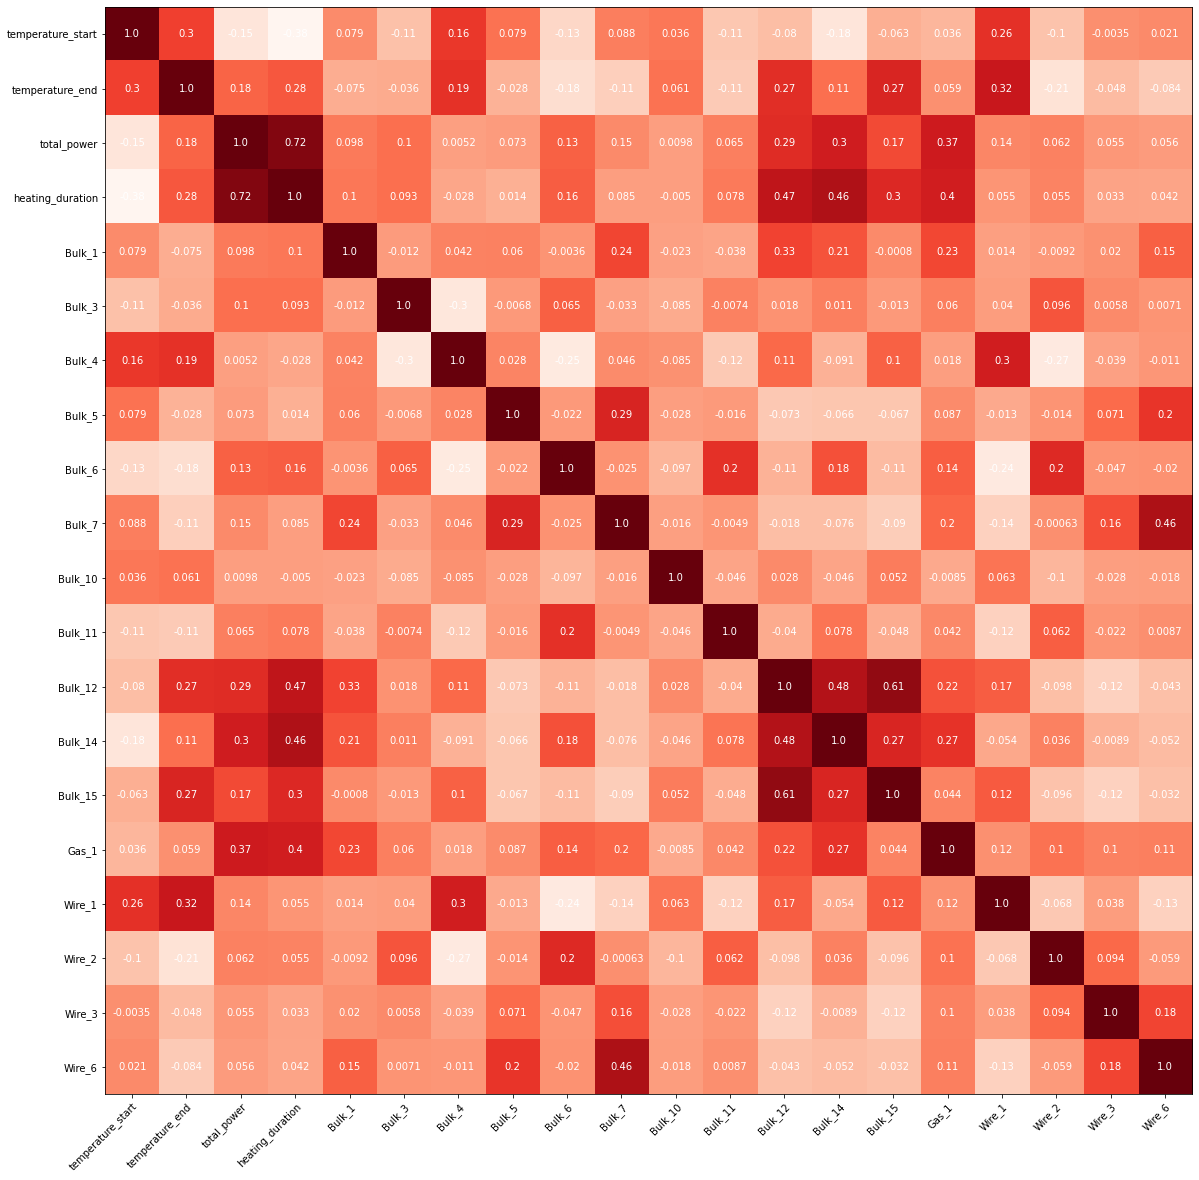

In [46]:
data_steel_knn = data_final.copy()
corr_heatmap_data = data_steel_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Conclusion from step 3 and 4: New features were generated - aggregated power, time at the beginning of the process, the target feature was identified and a collinearity analysis of the features was carried out. No signs with collinearity greater than 0.9 were found.

## Step 5. Data preparation

We divide the data into samples and perform scaling:

In [47]:
random_state = 12042024

features = data_final.drop('temperature_end', axis=1)
target = data_final['temperature_end']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv_counts = 5

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

We can start training models now
.

## Step 6. Train machine learning models

**Model
LinearRegression**

In [48]:
regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 6.485283590378136


MAE for LR =  6.48

**Model 2. RandomForestRegressor**

In [49]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 601, 50)], 
                'max_depth':[x for x in range(10, 19, 2)],
                'random_state':[random_state]}]
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)


Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 12, 'n_estimators': 400, 'random_state': 12042024}

Grid scores on development set:

6.339545 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 100, 'random_state': 12042024}
6.325205 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 150, 'random_state': 12042024}
6.326119 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200, 'random_state': 12042024}
6.315965 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 250, 'random_state': 12042024}
6.314011 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 300, 'random_state': 12042024}
6.316996 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 350, 'random_state': 12042024}
6.314845 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 400, 'random_state': 12042024}
6.314834 for {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 450, 'random_state': 12042024}
6.315682 for {'criterion': 'mse', 'max_depth': 10

Lowest MAE 6.3 for parameters 'max_depth': 12, 'n_estimators': 400.

Посмотрим на важность признаков:

In [ ]:
regressor = RandomForestRegressor(max_depth=16,n_estimators=450, random_state=random_state)
regressor.fit(features_train, target_train)
importances = regressor.feature_importances_
feature_names=features.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Decrease in impurity")

fig.tight_layout()

The attributes "temperature_start", "heatingduration", "Bulk_12", "Gas1", "Wire_1" have the greatest impact on the target feature.

**Model 3.XboostRegressor**

In [51]:
regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[0.01, 0.05, 0.07, 0.08, 0.1, 1],
                'random_state':[random_state]                
                 }]
#[x/100 for x in range(1, 51)]
print()
model_XGB = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
model_XGB.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = model_XGB.best_params_
print(model_XGB.best_params_)
print()
print("Grid scores on development set:")
print()
means = model_XGB.cv_results_['mean_test_score']
stds = model_XGB.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model_XGB.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)


Best parameters set found on development set:

{'learning_rate': 0.08, 'random_state': 12042024}

Grid scores on development set:

583.430665 for {'learning_rate': 0.01, 'random_state': 12042024}
10.674086 for {'learning_rate': 0.05, 'random_state': 12042024}
6.326028 for {'learning_rate': 0.07, 'random_state': 12042024}
6.281906 for {'learning_rate': 0.08, 'random_state': 12042024}
6.302055 for {'learning_rate': 0.1, 'random_state': 12042024}
8.237537 for {'learning_rate': 1, 'random_state': 12042024}



The smallest MAE for XboostRegressor 6.28 was achieved with learning_rate 0.08

Let's look at the importance of the factors.

In [ ]:
model = XGBRegressor()
model.fit(features_train, target_train)
print(model.feature_importances_)
# plot
feature_importances = model.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)


plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
plt.title('Feature importance')
plt.show()

The most important features are Wire 6, heating duration, Bulk 7.

**Model 4. CatBoostRegressor**

In [53]:

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 6.290529676104917


In [54]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12042024,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04471199959516525,
 'score_function': 'Cosine',
 'tas

Для Catboost метрика MAE составляет  ~~7.35~~ 6.29.

## Step 7. Selecting the best model

Let's test the best model on test data:

In [55]:
model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of XGBRegressor =', test_MAE_XGBR)

MAE on test of XGBRegressor = 5.986269288365674


On test data, the MAE metric is 5.98

## Step 8. General conclusion and recommendations to the customer

- Data on the steel melting process were obtained. Data types have been changed, omissions and outliers have been handled. Unnecessary data has been removed.
- Signs have been prepared. A single table was compiled with all the data for the model. The target feature is highlighted as the last measurement in a series of measurements. The data is divided into features and target with data mixing.
- Several models were trained with selection of parameters. The importance of the features was analyzed: the most important were “temperature_start”, “total_power”, “Bulk_12”, “Gas1”, “Wire_1”, “Wire 4”. By adjusting their values during production, you can optimize the process and reduce energy costs.
- The effectiveness of the model was assessed on a test sample.
The best model turned out to be XGBRegressor with a mae value on the test sample of 5.9